<img src="resources/header.png"/>

# Determining the pattern of missing data and imputing missing values in BayesDB
Authored by: Christina Curlette of the MIT Probabilistic Computing Project (Probcomp). Prepared for: The DARPA PPAML PI meeting, July 2017.

This notebook demonstrates two workflows with BayesDB:

1. Analyzing patterns of missing data
2. Imputing missing values, and evaluating how well the imputations are calibrated.

When analyzing a dataset, we are often interested in determining whether values in a dataset are missing at random, or are missing according to systematic pattern. In this notebook, we show an example of such an analysis task on a dataset from [Gapminder](https://gapminder.org), which contains macroeconomic indicators of countries for the year 2000. Our anlaysis will suggest that data are indeed not missing at random; instead, the patterns of missingness reflect (i) geographic/economic properties of the countries, (2) processes related to data collection, and (iii) processes related to violent conflict/civil unrest.

Another task of interest in data analysis is inferring likely values of missing data. BayesDB uses information from the joint distribution of all variables in the dataset to make inferences about the likely values of missing data. Our workflow will first censor several values of missingness indicators -- that is, binary-valued variables indicating whether values were missing in the original dataset -- and then infer them using BayesDB. We then evaluate whether the imputations are well-calibrated -- that is, whether the average confidence of imputations matches the average accuracy of imputations for each variable considered.

### Setting up the environment

Load `jupyter_probcomp` magics, enable plotting, and load a bdb file to store tables, populations, and models for this analysis.

In [1]:
%load_ext jupyter_probcomp.magics

session_id: fsaad@probcomp-1.csail.mit.edu_2017-12-17T11:22:13.218743_8


In [2]:
%matplotlib inline
%vizgpm inline

<IPython.core.display.Javascript object>

In [3]:
!rm -f resources/gapminder_missing_data.bdb
%bayesdb -j resources/gapminder_missing_data.bdb

u'Loaded: resources/gapminder_missing_data.bdb'

## 1. Analyzing patterns of missing data

### Creating a table

We create a table in the database from a csv file, in which each entry is 0 if a value for that variable was present in the original data and 1 if it was missing. We refer to the columns in this table as missingness indicators.

In [4]:
%bql CREATE TABLE gapminder_missing_t FROM 'resources/frame_missing_2000.csv'

""


Here are the first five rows of the data table. There are 23 columns in total.

In [5]:
%bql SELECT * FROM gapminder_missing_t LIMIT 5

,country_id,country,continent,year,missing_aid_received,missing_invest_foreign_per1k,missing_invest_domestic_per1k,missing_spending_health_per1,missing_gdp_per1k,missing_mortality_kid,missing_life_expectancy,missing_mortality_maternal,missing_population,missing_population_density,missing_surface,missing_gini,missing_continent,missing_completion,missing_agriculture,missing_physicians,missing_hiv,missing_malaria,missing_professional_birth,missing_sugar,missing_food,missing_infection,missing_labor,missing_broadband,missing_cell_phone,missing_internet,missing_computers,missing_it_tel,missing_sanitation,missing_water_source,missing_drought,missing_earthquake,missing_epidemic,missing_extreme_temp,missing_flood,missing_storm,missing_tsunami,missing_air_accident,missing_immune_diphtheria,missing_immune_hepatitis,missing_immune_hib,missing_mcv,missing_immune_tetanus,missing_energy_per1,missing_coal_per1,missing_electricity_per1,missing_oil_per1,missing_natural_gas_per1,missing_co2_per1
0,2,Afghanistan,Asia,2000,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,1,1,1,0
1,4,Albania,Europe,2000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0
2,5,Algeria,Africa,2000,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
3,8,Angola,Africa,2000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,1,0
4,11,Argentina,Americas,2000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0


### Creating a population

Because missingness indicators take on values 0 and 1, we model them as `NOMINAL`. We will further `IGNORE` columns indicating the country, ID, continent, and year, because we are only interested in modeling patterns of missing values.

In [6]:
%%mml
CREATE POPULATION gapminder_missing FOR gapminder_missing_t WITH SCHEMA (

    IGNORE
        "country_id", 
        "country",
        "continent",
        "year";
    
    SET STATTYPES OF 
         "missing_electricity_per1",
         "missing_hiv",
         "missing_aid_received",
         "missing_immune_hib",
         "missing_coal_per1",
         "missing_water_source",
         "missing_sanitation",
         "missing_professional_birth",
         "missing_energy_per1",
         "missing_immune_tetanus",
         "missing_invest_domestic_per1k",
         "missing_completion",
         "missing_oil_per1",
         "missing_co2_per1",
         "missing_surface",
         "missing_population",
         "missing_agriculture",
         "missing_natural_gas_per1",
         "missing_infection",
         "missing_gini",
         "missing_life_expectancy",
         "missing_immune_hepatitis",
         "missing_gdp_per1k",
         "missing_physicians",
         "missing_cell_phone",
         "missing_population_density",
         "missing_computers",
         "missing_mcv",
         "missing_epidemic",
         "missing_mortality_kid",
         "missing_air_accident",
         "missing_immune_diphtheria",
         "missing_invest_foreign_per1k",
         "missing_sugar",
         "missing_extreme_temp",
         "missing_spending_health_per1",
         "missing_storm",
         "missing_food",
         "missing_internet",
         "missing_tsunami",
         "missing_it_tel",
         "missing_mortality_maternal",
         "missing_earthquake",
         "missing_labor",
         "missing_continent",   
         "missing_broadband",
         "missing_drought",
         "missing_flood",
         "missing_malaria" 
    TO 
        NOMINAL;
)

""


### Analyzing the data

As demonstrated in the Gapminder [exploratory notebook](gapminder-exploratory.ipynb), we create a general for the population and specify CrossCat as the baseline model discovery engine.

In [7]:
%mml CREATE GENERATOR gapminder_missing_crosscat FOR gapminder_missing;

""


We initialize 16 analyses, and run analysis for 1 minute.

In [8]:
%mml INITIALIZE 16 MODELS FOR gapminder_missing_crosscat

""


In [9]:
%mml ANALYZE gapminder_missing_crosscat FOR 1 MINUTE (OPTIMIZED)

Completed: 353 iterations in 60.092464 seconds.
Completed: 353 iterations in 60.065920 seconds.
Completed: 374 iterations in 60.017905 seconds.
Completed: 341 iterations in 60.000683 seconds.
Completed: 362 iterations in 60.094256 seconds.
Completed: 351 iterations in 60.075259 seconds.
Completed: 368 iterations in 60.018610 seconds.
Completed: 345 iterations in 60.060494 seconds.
Completed: 343 iterations in 60.099572 seconds.
Completed: 355 iterations in 60.138009 seconds.
Completed: 357 iterations in 60.076759 seconds.
Completed: 355 iterations in 60.144618 seconds.
Completed: 364 iterations in 60.162260 seconds.
Completed: 354 iterations in 60.144143 seconds.
Completed: 342 iterations in 60.193992 seconds.
Completed: 360 iterations in 60.189412 seconds.


""


### 1.1 Finding likely dependencies between missingness indicators

Now that we have run analysis, we can query the model to estimate the probability of dependence between pairs of missingness indicators. If the data were missing at random, we would expect all of the dependence probabilities to be zero. Conversely, if the data were not missing at random, we would expect to see nonzero dependence probabilities and clusters of variables whose missingness is likely to be interdependent.

In [10]:
%%bql
CREATE TABLE dependence_probabilities AS 
ESTIMATE
    DEPENDENCE PROBABILITY AS "depprob"
FROM PAIRWISE VARIABLES OF gapminder_missing

""


In [11]:
%bql .interactive_heatmap SELECT name0, name1, depprob FROM dependence_probabilities

<IPython.core.display.Javascript object>

We can see in the above heatmap that there are distinct clusterings of missingness indicators that are likely to be dependent on one another. This suggests that the data are **not missing at random**. One notable pattern is that `water` and `sanitation` are in their own cluster. We can check to see if they tend to both be missing at the same time:


In [12]:
%bql SELECT COUNT(*) FROM gapminder_missing_t WHERE "missing_water_source" = "missing_sanitation"

,"""COUNT""(*)"
0,169


For 169 of 170 countries, the `water_source` and `sanitation` values are either both missing or both present.

In [13]:
%bql SELECT DISTINCT "missing_sanitation", COUNT(*) FROM gapminder_missing_t GROUP BY "missing_sanitation"

,missing_sanitation,"""COUNT""(*)"
0,0,150
1,1,20


In addition, the values are not missing across the board, so it seems that the pattern is significant. One possible cause could be that data for these two variables are collected together.

### 1.2 Countries' similarity in the context of missingness indicators

We can also look at similarity between countries in the context of particular missingness indicators. We show similarity in the context of two missingness indicators below: (1) `missing_physicians`  and (2) `missing_food`. The patterns of similarity reflect geographic and economic properties of the countries as well as regions in which war and conflicts were occurring in 2000.

#### Missing physicians


In [14]:
%%bql
CREATE TABLE similarity_missing_physicians AS
ESTIMATE
    SIMILARITY IN THE CONTEXT OF missing_physicians
FROM PAIRWISE gapminder_missing

""


In [15]:
%%bql 
.interactive_heatmap --table=gapminder_missing_t --label0=rowid --label1=country
SELECT * FROM similarity_missing_physicians

<IPython.core.display.Javascript object>

The heatmap above shows roughly 5 clusters of countries that are similar in the context of `missing_physicians`. These clusters relate to common-sense geographic and political groupings, e.g. mostly African countries; US, Australia, and Western European countries.

#### Missing food

In [16]:
%%bql
CREATE TABLE similarity_missing_food AS
ESTIMATE
    SIMILARITY IN THE CONTEXT OF missing_food
FROM PAIRWISE gapminder_missing

""


In [17]:
%%bql 
.interactive_heatmap --table=gapminder_missing_t --label0=rowid --label1=country 
SELECT * FROM similarity_missing_food

<IPython.core.display.Javascript object>

The variable `food` happens to be rarely missing in this dataset. If a country has `food` missing, it is likely that the country is experiencing civil or political unrest that prevents it from participating in Gapminder data collection. It is clear from this heatmap that BayesDB has learned implicitly which countries had major conflicts or civil unrest in the year 2000 -- those in the bottom right corner of the heatmap that do not group with the large cluster. This includes countries such as Afghanistan, Somalia, Iraq, Serbia and Montenegro.

## 2. Imputing missing values

In this section, we use the same data as in the previous section -- missingness indicators for Gapminder data in 2000. We select a small subset of missingness indicators and randomly selected rows for each missingness indicator to censor values for (that is, set them to null) and use BayesDB to infer the missing value (0 or 1 for each). After imputing the values, we can evaluate how well-calibrated the imputations are. 

#### Censoring and imputing values

We will be imputing values for 6 missingness indicators and 20 randomly selected rows for each. Let's first create a copy of the `gapminder_missing_t` table and name it `gapminder_missing_censored_t` (because we will be censoring the values we wish to impute).

In [18]:
%bql CREATE TABLE gapminder_missing_censored_t AS SELECT * FROM gapminder_missing_t

""


For each of the six missing indicators to censor, we select 20 rows at random to drop. The values for each (column, row) index are set to `NULL`, so we can run analysis on the remainder of the data and then impute the censored values.

In [19]:
import numpy as np;
rng = np.random.RandomState(1)
drop = {
    'missing_oil_per1'               : tuple(rng.choice(range(171), size=20, replace=False)),
    'missing_invest_domestic_per1k'  : tuple(rng.choice(range(171), size=20, replace=False)),
    'missing_sanitation'             : tuple(rng.choice(range(171), size=20, replace=False)),
    'missing_completion'             : tuple(rng.choice(range(171), size=20, replace=False)),
    'missing_co2_per1'               : tuple(rng.choice(range(171), size=20, replace=False)),
    'missing_hiv'                    : tuple(rng.choice(range(171), size=20, replace=False)),
}

for column, rowids in drop.iteritems():
    %sql UPDATE gapminder_missing_censored_t SET {column} = NULL WHERE rowid IN {rowids}

As in Section 1, we create a population for the data using the same modeling schema. We then create an analysis schema specifying CrossCat as the baseline model discovery engine, initialize 16 analyses and run analysis for 1 minute.

In [20]:
%%mml
CREATE POPULATION gapminder_missing_censored FOR gapminder_missing_censored_t WITH SCHEMA (
    IGNORE
        "country_id", 
        "country",
        "continent",
        "year";
    
    SET STATTYPES OF 
         "missing_electricity_per1",
         "missing_hiv",
         "missing_aid_received",
         "missing_immune_hib",
         "missing_coal_per1",
         "missing_water_source",
         "missing_sanitation",
         "missing_professional_birth",
         "missing_energy_per1",
         "missing_immune_tetanus",
         "missing_invest_domestic_per1k",
         "missing_completion",
         "missing_oil_per1",
         "missing_co2_per1",
         "missing_surface",
         "missing_population",
         "missing_agriculture",
         "missing_natural_gas_per1",
         "missing_infection",
         "missing_gini",
         "missing_life_expectancy",
         "missing_immune_hepatitis",
         "missing_gdp_per1k",
         "missing_physicians",
         "missing_cell_phone",
         "missing_population_density",
         "missing_computers",
         "missing_mcv",
         "missing_epidemic",
         "missing_mortality_kid",
         "missing_air_accident",
         "missing_immune_diphtheria",
         "missing_invest_foreign_per1k",
         "missing_sugar",
         "missing_extreme_temp",
         "missing_spending_health_per1",
         "missing_storm",
         "missing_food",
         "missing_internet",
         "missing_tsunami",
         "missing_it_tel",
         "missing_mortality_maternal",
         "missing_earthquake",
         "missing_labor",
         "missing_continent",   
         "missing_broadband",
         "missing_drought",
         "missing_flood",
         "missing_malaria" 
    TO 
        NOMINAL;
)

""


In [21]:
%%mml
CREATE GENERATOR gapminder_missing_censored_crosscat FOR gapminder_missing_censored;

""


In [22]:
%mml INITIALIZE 16 MODELS FOR gapminder_missing_censored_crosscat

""


In [23]:
%mml ANALYZE gapminder_missing_censored_crosscat FOR 1 MINUTE (OPTIMIZED);

Completed: 346 iterations in 60.008617 seconds.
Completed: 341 iterations in 60.026304 seconds.
Completed: 355 iterations in 60.054815 seconds.
Completed: 354 iterations in 60.034388 seconds.
Completed: 353 iterations in 60.059112 seconds.
Completed: 355 iterations in 60.049965 seconds.
Completed: 385 iterations in 60.051992 seconds.
Completed: 335 iterations in 60.062847 seconds.
Completed: 348 iterations in 60.092394 seconds.
Completed: 373 iterations in 60.100577 seconds.
Completed: 357 iterations in 60.090381 seconds.
Completed: 335 iterations in 60.098028 seconds.
Completed: 354 iterations in 60.105813 seconds.
Completed: 351 iterations in 60.107019 seconds.
Completed: 354 iterations in 60.157602 seconds.
Completed: 378 iterations in 60.154209 seconds.


""


Now, we can use the model to impute missing values. We create a table below to store relevant information about the imputations. For each imputation we store the column name, row number, imputed value, confidence of the imputation, true value, and whether the imputation was correct.

In [24]:
%%sql 
CREATE TABLE imputation_results (
    col_name TEXT,
    row_num INTEGER,
    imputed_value INTEGER,
    confidence REAL,
    true_value INTEGER,
    is_correct INTEGER
)

""


The following cell loops through each column and row and performs the imputation using `INFER EXPLICIT PREDICT`. Each imputation uses 20 samples from the model. The confidence is equal to the fraction of imputations equal to the majority imputed value -- e.g. if 15 of 20 of the values were 0, the imputed value would be 0 and the confidence would be 0.75. If the imputed value matches the true value, it is considered correct. Please note that this cell may take ~5 minutes to run.

In [25]:
for col, rowids in drop.iteritems():
    print 'Imputing values for %s...' % (col,)
    for row in rowids:
        row = int(row)
        # Run the imputation.
        impute_results = \
            %bql INFER EXPLICIT \
                PREDICT {col} CONFIDENCE conf USING 20 SAMPLES \
            FROM gapminder_missing_censored \
            WHERE gapminder_missing_censored_t.rowid = {row}
        imputed_val = impute_results[col].iloc[0]
        conf = impute_results['conf'].iloc[0]
        # Retrieve the true value from `gapminder_missing`.
        true_val_df = %bql SELECT {col} FROM gapminder_missing_t WHERE rowid = {row}
        true_val = true_val_df.iloc[0,0]
        # Check if imputation correct and insert into `imputation_results`.
        correct = 1 if imputed_val == true_val else 0
        %sql INSERT INTO imputation_results \
                ("col_name", "row_num", "imputed_value", "confidence", "true_value", "is_correct") \
                VALUES ('{col}', {row}, {imputed_val}, {conf}, {true_val}, {correct})

Imputing values for missing_oil_per1...
Imputing values for missing_invest_domestic_per1k...
Imputing values for missing_sanitation...
Imputing values for missing_completion...
Imputing values for missing_co2_per1...
Imputing values for missing_hiv...


#### Evaluating calibration of imputations

Now that we have imputed the values, we can compute the average accuracy and average confidence on a per-variable basis. If the imputations are well-calibrated, we would expect the average accuracy and average confidence to be roughly equivalent. 

Below, we create a table to store the column name, average accuracy and average confidence of imputations for each column.

In [26]:
%%sql
CREATE TABLE aggregated_imputation_results AS
SELECT
    col_name,
    AVG(is_correct) AS avg_accuracy,
    AVG(confidence) AS avg_conf
FROM imputation_results
GROUP BY col_name

""


In [27]:
%sql SELECT * FROM aggregated_imputation_results

,col_name,avg_accuracy,avg_conf
0,missing_co2_per1,1.00,0.9850
1,missing_completion,0.40,0.6100
2,missing_hiv,0.85,0.8675
3,missing_invest_domestic_per1k,0.85,0.9175
4,missing_oil_per1,0.85,0.7650
5,missing_sanitation,0.90,0.8825


We can also plot the average accuracy vs. average confidence. 

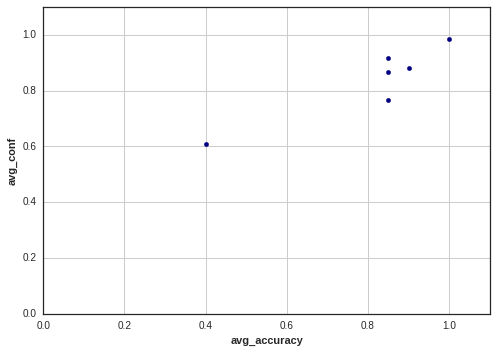

In [28]:
%%bql 
.scatter --xmin=0 --ymin=0 --xmax=1.1 --ymax=1.1
SELECT avg_accuracy, avg_conf FROM aggregated_imputation_results

From the plot above it appears that the points lie near the ideal calibration line, i.e. the line of slope 1 from the origin to (1,1). Imputation and calibration experiments can be run on a much larger scale with BayesDB as well. Using more variables, more iterations of analysis, more imputed values per variable and more samples per imputation can all increase the robustness of the results. 